LSTM model to predict Time to Failure

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model
import time
import tensorflow as tf
import h5py


In [2]:
## Function to create data history
# n_steps = 300 = 3s history
# Features (history): n-300, n-299, ... , n-2, n-1 
# Traget variable: n

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  #last column is the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'TTF':data['TTF'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3786:136185].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3786:136185].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'V_filt', 'maxFreqI_filt', 'Vel_pc','TTF']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc  ...  Vel_pc  TTF
0         31453.223522                0.0  ...     0.0  0.0
1         31438.277060                0.0  ...     0.0  0.0
2         31421.341616                0.0  ...     0.0  0.0
3         31409.798761                0.0  ...     0.0  0.0
4         31398.815589                0.0  ...     0.0  0.0
...                ...                ...  ...     ...  ...
132394    31055.686766                0.0  ...     0.0  0.0
132395    31041.955345                0.0  ...     0.0  0.0
132396    31035.059531                0.0  ...     0.0  0.0
132397    31020.001291                0.0  ...     0.0  0.0
132398    31012.016780                0.0  ...     0.0  0.0

[132399 rows x 6 columns]


In [4]:
# Preprocessing

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))


Features shape, X =  (132099, 300, 5)
Target shape, Y =  (132099,)


In [5]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Training: (95111, 300, 5)
Validation: (10568, 300, 5)
Testing: (26420, 300, 5)


Epoch 1/10
2973/2973 [==============================] - 61s 20ms/step - loss: 0.2796 - val_loss: 0.1271
Epoch 2/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0716 - val_loss: 0.1292
Epoch 3/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0604 - val_loss: 0.0812
Epoch 4/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0576 - val_loss: 0.0780
Epoch 5/10
2973/2973 [==============================] - 61s 20ms/step - loss: 0.0523 - val_loss: 0.0883
Epoch 6/10
2973/2973 [==============================] - 61s 20ms/step - loss: 0.0529 - val_loss: 0.1009
Epoch 7/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0490 - val_loss: 0.0954
Epoch 8/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0466 - val_loss: 0.1015
Epoch 9/10
2973/2973 [==============================] - 60s 20ms/step - loss: 0.0454 - val_loss: 0.1056
Epoch 10/10
2973/2973 [==============================] - 60s 20m

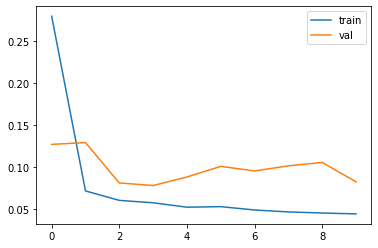

---Training time: 610.21630335 seconds ---
R2 scores: Train - 0.96374, Validation - 0.93793
RMSE scores: Train - 0.19958, Validation - 0.28720


In [6]:
# Build the model

np.random.seed(0)   # To get reproducible results
#tf.random.set_seed(0)

model = Sequential()
model.add(LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='tanh'))
#model.add(Dense(, kernel_initializer='normal', activation='relu'))
#model.add(Flatten())
model.add(Dense(1, kernel_initializer='normal', activation='relu'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))

y_predTrain = model.predict(X_train)
train_r2 = r2_score(Y_train, y_predTrain)
train_rmse = np.sqrt(mean_squared_error(Y_train, y_predTrain))

y_predVal = model.predict(X_val)
val_r2 = r2_score(Y_val, y_predVal)
val_rmse = np.sqrt(mean_squared_error(Y_val, y_predVal))  

print("R2 scores: Train - %0.5f, Validation - %0.5f" %(train_r2, val_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f" %(train_rmse, val_rmse))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 32)           4864      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________
None


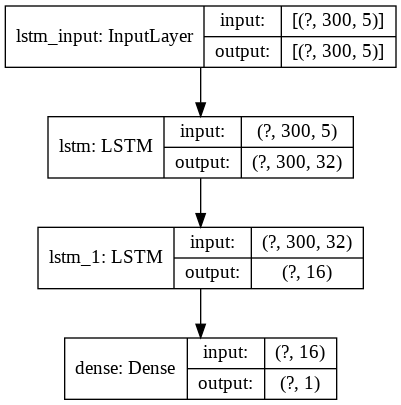

In [7]:
print(model.summary())
plot_model(model, show_shapes=True)
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_ttf.h5')

In [8]:
# Evaluate the model

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
test_r2 = r2_score(y_test, y_predTest)
test_rmse = np.sqrt(mean_squared_error(y_test, y_predTest))

print("Test - \nR2 scores: %0.5f \nRMSE scores: %0.5f" %(test_r2, test_rmse))
print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))

Test - 
R2 scores: 0.90198 
RMSE scores: 0.35951

---Time for Test data prediction: 6.73206687 seconds ---


Text(0.5, 1.0, 'Time to Failure prediction using LSTM model')

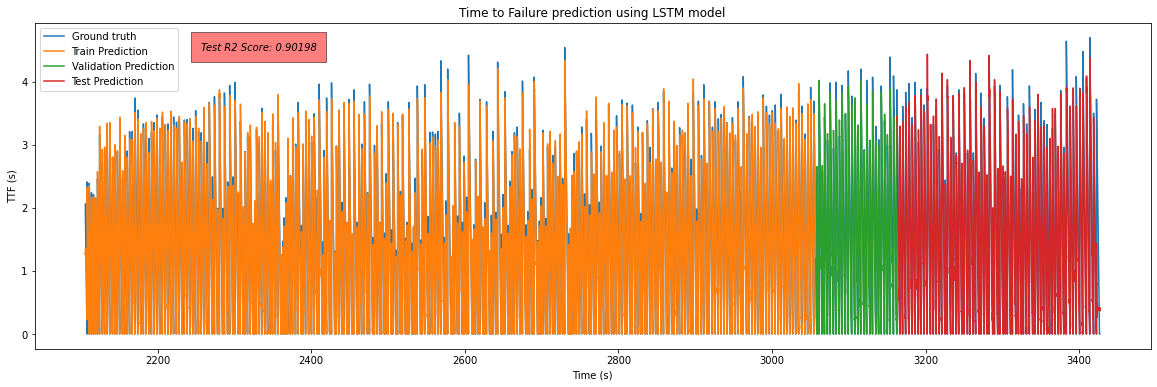

In [9]:
# Overall plot

ttime = df1['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf)
plt.plot(traintime, y_predTrain)
plt.plot(valtime, y_predVal)
plt.plot(testtime, y_predTest)
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.text(ttime.iloc[15000], 4.5, 'Test R2 Score: %0.5f' %(test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Time to Failure prediction using LSTM model')


In [ ]:
# Save predictions
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/res300/lstm_ttf.h5', 'w')
hf.create_dataset('y_predTrain', data=y_predTrain)
hf.create_dataset('y_predVal', data=y_predVal)
hf.create_dataset('y_predTest', data=y_predTest)
hf.close()
'''

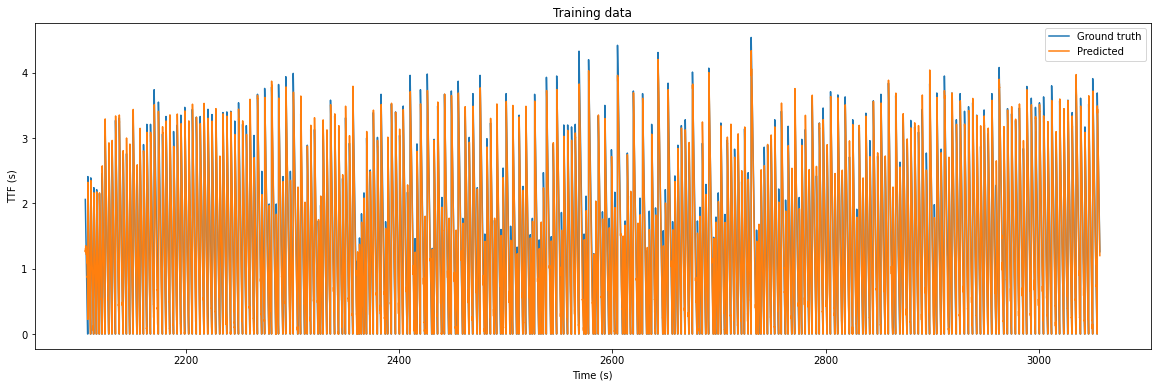

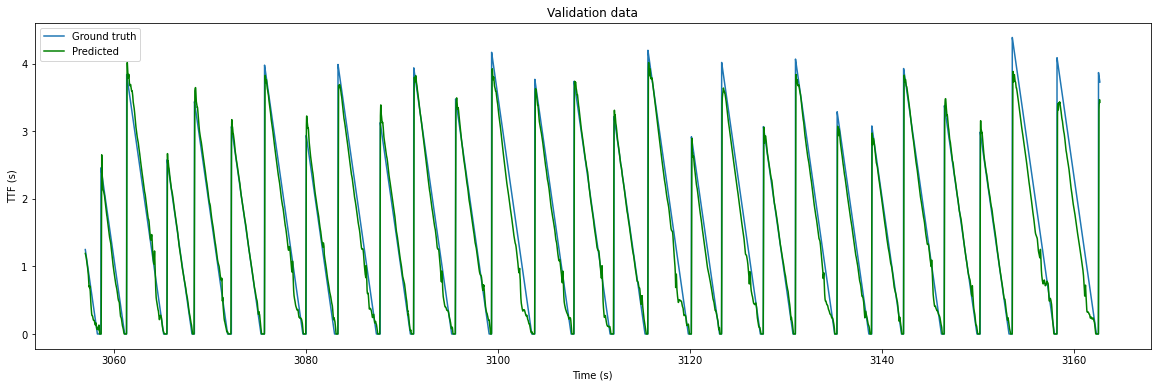

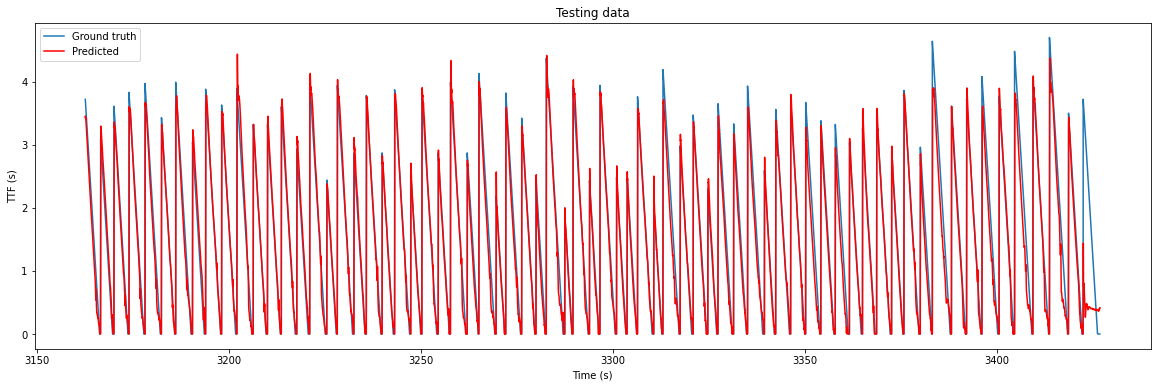

In [11]:
# Individual plots

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('TTF (s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train, y_predTrain, 'Training data', '')
results_plot(2, valtime, Y_val, y_predVal, 'Validation data', 'g')
results_plot(3, testtime, y_test, y_predTest, 'Testing data', 'r')


Text(0.5, 1.0, 'Detailed View, Testing Data')

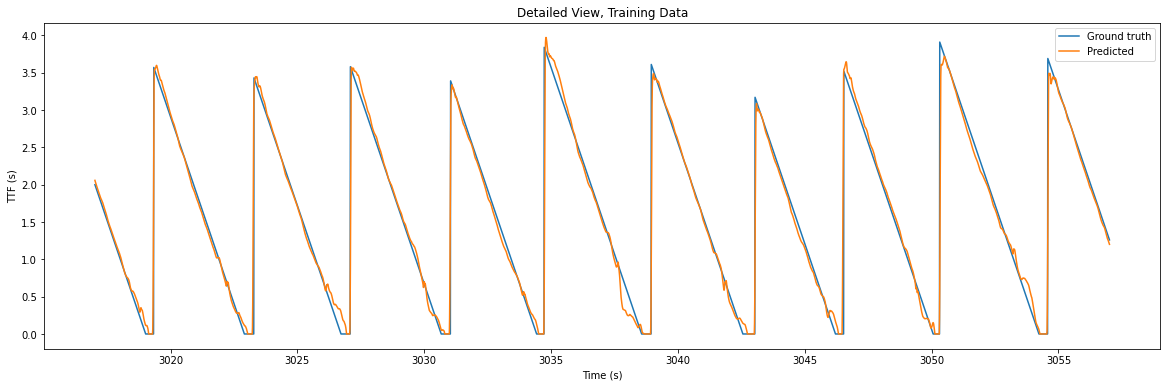

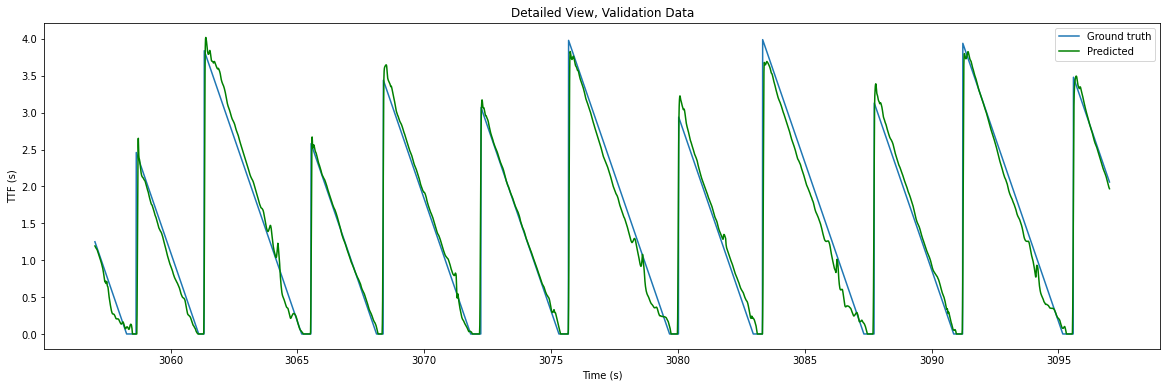

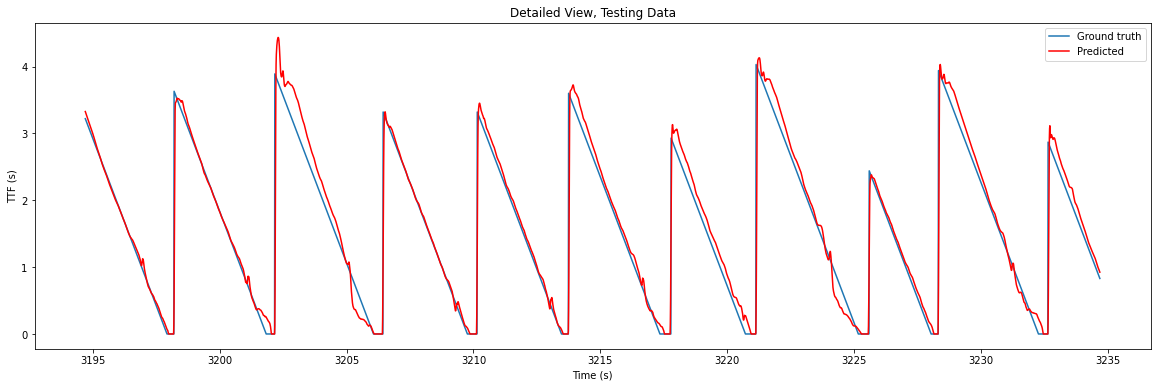

In [14]:
# Detailed view of the plots

n=4000

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:])
plt.plot(traintime[-n:], y_predTrain[-n:])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n])
plt.plot(valtime[:n], y_predVal[:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n])
plt.plot(testtime[st_i:st_i+n], y_predTest[st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')
